# RBF-Based MLP in Keras for Stress Reduction Analysis
This notebook builds a Radial Basis Function Multi-Layer Perceptron using Keras to predict stress-related metrics after yoga.

In [59]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all logs, 3 = fatal only
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Layer, Dense, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display
warnings.filterwarnings("ignore", category=FutureWarning)

In [60]:
# Define custom RBF layer
class RBFLayer(Layer):
    def __init__(self, units, gamma=1.0, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = gamma

    def build(self, input_shape):
        self.centers = self.add_weight(name='centers',
                                       shape=(self.units, input_shape[-1]),
                                       initializer='uniform',
                                       trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = tf.expand_dims(inputs, 1) - self.centers
        l2 = tf.reduce_sum(tf.square(diff), axis=-1)
        return tf.exp(-self.gamma * l2)

In [61]:
# Build RBF MLP Model
def build_rbf_mlp(input_dim, rbf_units=10, gamma=0.5):
    inputs = Input(shape=(input_dim,))
    x = RBFLayer(units=rbf_units, gamma=gamma)(inputs)
    x = Dense(16, activation='relu')(x)
    x = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=x)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [62]:
# Load your dataset
df = pd.read_csv('/kaggle/input/individual/id4.csv')
df.columns = df.columns.str.strip()  # strip whitespace

# Optional: drop unnamed columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Display Table 1: Original Data (with NaNs)
print("\nTable 1: Original Data with NaNs")
display(df.head().style.set_caption("Original Dataset with Missing Values").set_table_styles([{
    'selector': 'caption',
    'props': [('color', 'black'), ('font-size', '16px'), ('text-align', 'center')]
}]))

# Fill NaNs using column-wise mean for numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns  # select numeric columns
df_filled_mean = df.copy()
df_filled_mean[numeric_cols] = df_filled_mean[numeric_cols].fillna(df_filled_mean[numeric_cols].mean())

# Display Table 2: Data after filling NaNs with mean
print("\nTable 2: Data with NaNs Filled (Column-wise Mean)")
display(df_filled_mean.head().style.set_caption("NaN-Filled Dataset (Mean Method)").set_table_styles([{
    'selector': 'caption',
    'props': [('color', 'black'), ('font-size', '16px'), ('text-align', 'center')]
}]))

# Define features and target variables
X = df.drop(columns=['Date'])  # Exclude the 'Date' column
y = X  # All other columns are considered target variables


# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Table 1: Original Data with NaNs


,Date,Energy Field,Stress,Alpha,Beta,Theta,Stress Index,Relaxation Index,HRV,Post Yoga Energy Field,Post Yoga stress,Post Yoga Alpha,Post yoga Beta,Post yoga Theta,Post Yoga Stress Index,Post Yoga Relaxation Index,Post Yoga HRV
0,25.03.2025,51,2.900000,nan,nan,nan,nan,nan,nan,51,2.870000,nan,nan,nan,nan,nan,nan
1,26.03.2025,45,2.520000,7.350000,17.760000,4.850000,125.320000,0.490000,98.000000,52,2.480000,8.310000,15.300000,4.750000,90.000000,0.700000,89.000000
2,27.03.2025,52,3.110000,7.590000,16.140000,5.170000,127.320000,0.450000,97.000000,52,2.940000,8.480000,15.010000,5.010000,85.000000,0.650000,85.000000
3,03.04.2025,40,2.910000,nan,nan,nan,nan,nan,nan,40,2.810000,nan,nan,nan,nan,nan,nan
4,04.04.2025,42,2.840000,8.010000,15.310000,5.130000,155.270000,0.250000,88.000000,42,2.740000,8.650000,14.330000,4.890000,78.000000,0.500000,79.000000



Table 2: Data with NaNs Filled (Column-wise Mean)


,Date,Energy Field,Stress,Alpha,Beta,Theta,Stress Index,Relaxation Index,HRV,Post Yoga Energy Field,Post Yoga stress,Post Yoga Alpha,Post yoga Beta,Post yoga Theta,Post Yoga Stress Index,Post Yoga Relaxation Index,Post Yoga HRV
0,25.03.2025,51,2.900000,7.790000,16.127500,5.095000,141.030000,0.385000,91.000000,51,2.870000,8.537500,14.655000,4.840000,77.250000,0.600000,81.250000
1,26.03.2025,45,2.520000,7.350000,17.760000,4.850000,125.320000,0.490000,98.000000,52,2.480000,8.310000,15.300000,4.750000,90.000000,0.700000,89.000000
2,27.03.2025,52,3.110000,7.590000,16.140000,5.170000,127.320000,0.450000,97.000000,52,2.940000,8.480000,15.010000,5.010000,85.000000,0.650000,85.000000
3,03.04.2025,40,2.910000,7.790000,16.127500,5.095000,141.030000,0.385000,91.000000,40,2.810000,8.537500,14.655000,4.840000,77.250000,0.600000,81.250000
4,04.04.2025,42,2.840000,8.010000,15.310000,5.130000,155.270000,0.250000,88.000000,42,2.740000,8.650000,14.330000,4.890000,78.000000,0.500000,79.000000


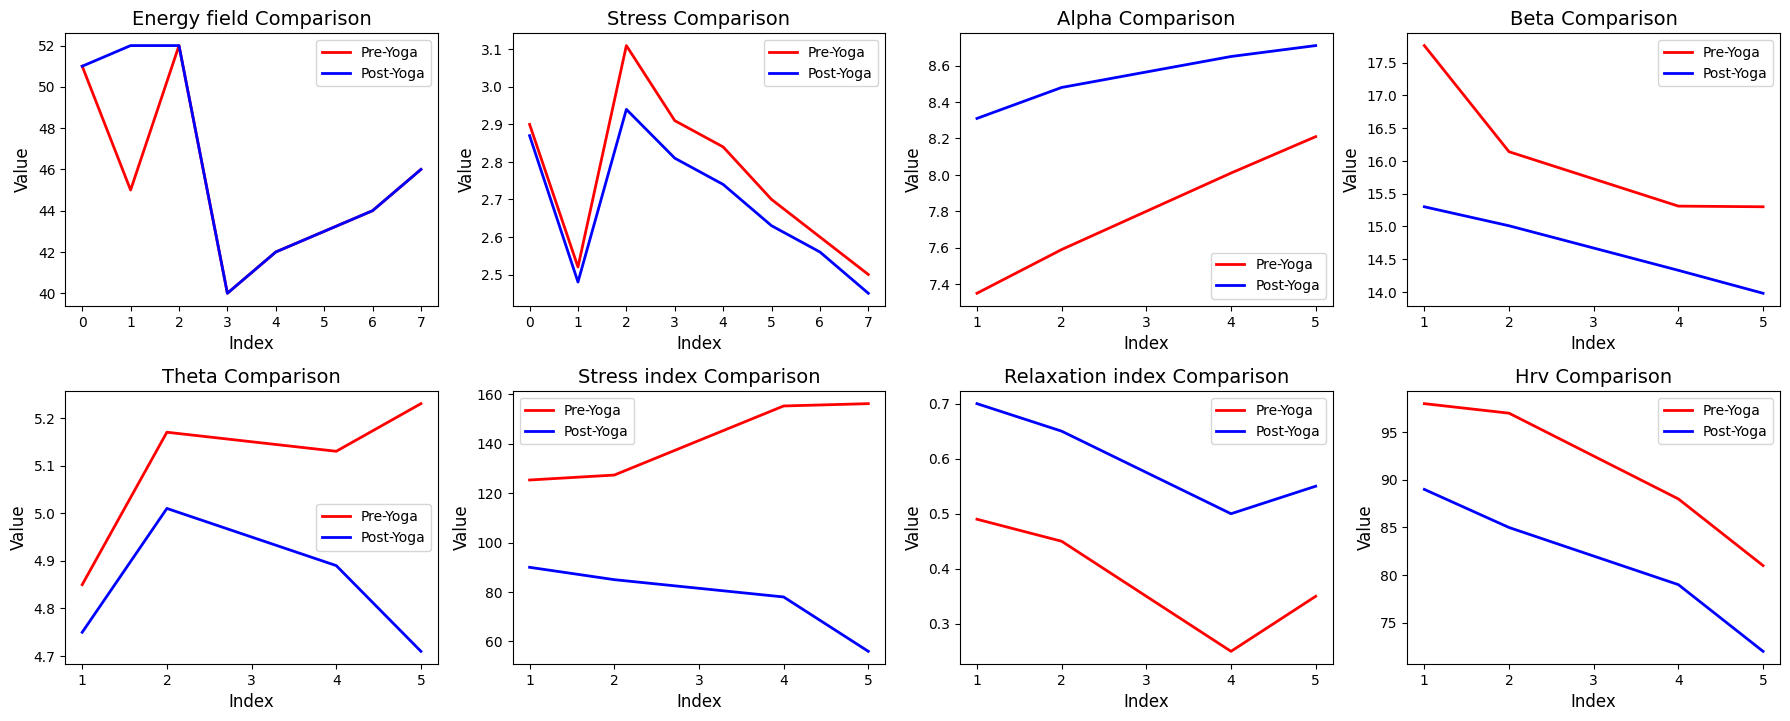

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert column names to lowercase for consistent matching
df.columns = df.columns.str.lower()

# Set the color palette for the plot
sns.set_palette("dark:blue", desat=0.7)

# Create subplots for each pre and post feature comparison
features = ['energy field', 'stress', 'alpha', 'beta', 'theta', 'stress index', 'relaxation index', 'hrv']

# Create a visually appealing plot with high resolution
plt.figure(figsize=(18, 14))  # Increased figure size

for i, feature in enumerate(features):
    plt.subplot(4, 4, i + 1)  # Create a grid of 4x4 subplots
    # Plot pre data (e.g., 'energy field')
    sns.lineplot(data=df, x=df.index, y=feature, color='red', label='Pre-Yoga', linewidth=2)
    
    # Construct the corresponding 'Post Yoga' column name (e.g., 'post yoga energy field')
    post_feature = 'post yoga ' + feature
    if post_feature in df.columns:
        sns.lineplot(data=df, x=df.index, y=post_feature, color='blue', label='Post-Yoga', linewidth=2)
    else:
        print(f"Warning: Column '{post_feature}' not found in dataset.")
    
    # Title and labels for each subplot
    plt.title(f"{feature.capitalize()} Comparison", fontsize=14)
    plt.xlabel("Index", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.legend()

# Adjust layout to avoid overlapping subplots
plt.tight_layout()
plt.show()

In [64]:
print(df.columns)

Index(['date', 'energy field', 'stress', 'alpha', 'beta', 'theta',
       'stress index', 'relaxation index', 'hrv', 'post yoga energy field',
       'post yoga stress', 'post yoga alpha', 'post yoga beta',
       'post yoga theta', 'post yoga stress index',
       'post yoga relaxation index', 'post yoga hrv'],
      dtype='object')


In [65]:
import pandas as pd
import os

# Path to the folder containing the CSV files
folder_path = "/kaggle/input/experimental"

# Dictionary to store cleaned DataFrames with file name as key
cleaned_dfs = {}

# Loop over each file in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):
        file_path = os.path.join(folder_path, file_name)
        
        # Read the CSV
        df = pd.read_csv(file_path)
        
        # Standardize column names: lowercase and strip whitespace
        df.columns = [col.strip().lower() for col in df.columns]
        
        # Fill NaN values with column-wise mean
        df = df.apply(lambda x: x.fillna(x.mean()) if x.dtype != 'O' else x)
        
        # Store in dictionary
        cleaned_dfs[file_name] = df

print("✅ All experimental CSVs cleaned and stored in memory.")

✅ All experimental CSVs cleaned and stored in memory.


In [66]:
import pandas as pd
import os

# Path to your experimental data folder
folder_path = "/kaggle/input/experimental"

# Dictionary to hold cleaned DataFrames
cleaned_dfs = {}

# Read, clean, and store each file
for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        
        # Clean column names
        df.columns = [col.strip().lower() for col in df.columns]
        
        # Fill NaNs with column mean
        df = df.apply(lambda x: x.fillna(x.mean()) if x.dtype != 'O' else x)
        
        # Save to dictionary
        cleaned_dfs[file_name] = df

# Display top 10 rows of each cleaned file
for name, df in cleaned_dfs.items():
    print(f"\n📄 {name}")
    display(df.head(10))


📄 id7.csv


,date,energy field,stress,alpha,beta,theta,stress index,relaxation index,hrv,post yoga energy field,post yoga stress,post yoga alpha,post yoga beta,post yoga theta,post yoga stress index,post yoga relaxation index,post yoga hrv
0,18.03.2025,42,2.74,8.56,15.08,5.28,130.52,0.3,72.0,44.5,2.611667,9.05,17.94,6.89,75.0,0.57,73.0
1,19.03.2025,46,2.96,8.56,15.08,5.28,130.52,0.3,72.0,44.5,2.611667,9.05,17.94,6.89,75.0,0.57,73.0
2,20.03.2025,39,2.92,8.56,15.08,5.28,130.52,0.3,72.0,39.0,2.820000,9.05,17.94,6.89,75.0,0.57,73.0
3,21.03.2025,41,2.80,8.56,15.08,5.28,130.52,0.3,72.0,41.0,2.710000,9.05,17.94,6.89,75.0,0.57,73.0
4,24.03.2025,47,2.86,8.56,15.08,5.28,130.52,0.3,72.0,47.0,2.750000,9.05,17.94,6.89,75.0,0.57,73.0
5,26.03.2025,45,2.60,8.56,15.08,5.28,130.52,0.3,72.0,45.0,2.540000,9.05,17.94,6.89,75.0,0.57,73.0
6,27.03.2025,46,2.65,8.56,15.08,5.28,130.52,0.3,72.0,46.0,2.510000,9.05,17.94,6.89,75.0,0.57,73.0
7,07.04.2025,49,2.44,8.56,15.08,5.28,130.52,0.3,72.0,49.0,2.340000,9.05,17.94,6.89,75.0,0.57,73.0



📄 id5.csv


,date,energy field,stress,alpha,beta,theta,stress index,relaxation index,hrv,post yoga energy field,post yoga stress,post yoga alpha,post yoga beta,post yoga theta,post yoga stress index,post yoga relaxation index,post yoga hrv
0,17.03.2025,40,3.29,7.93,23.89,7.56,145.76,0.41,97.0,44.0,2.918571,8.67,18.92,6.05,75.0,0.65,95.0
1,18.03.2025,39,3.50,7.93,23.89,7.56,145.76,0.41,97.0,44.0,2.918571,8.67,18.92,6.05,75.0,0.65,95.0
2,20.03.2025,38,3.20,7.93,23.89,7.56,145.76,0.41,97.0,38.0,3.100000,8.67,18.92,6.05,75.0,0.65,95.0
3,24.03.2025,41,3.10,7.93,23.89,7.56,145.76,0.41,97.0,41.0,3.090000,8.67,18.92,6.05,75.0,0.65,95.0
4,26.03.2025,45,3.00,7.93,23.89,7.56,145.76,0.41,97.0,45.0,2.970000,8.67,18.92,6.05,75.0,0.65,95.0
5,27.03.2025,43,2.95,7.93,23.89,7.56,145.76,0.41,97.0,43.0,2.900000,8.67,18.92,6.05,75.0,0.65,95.0
6,28.03.2025,47,2.98,7.93,23.89,7.56,145.76,0.41,97.0,47.0,2.960000,8.67,18.92,6.05,75.0,0.65,95.0
7,07.04.2025,48,2.80,7.93,23.89,7.56,145.76,0.41,97.0,48.0,2.760000,8.67,18.92,6.05,75.0,0.65,95.0
8,08.04.2025,46,2.84,7.93,23.89,7.56,145.76,0.41,97.0,46.0,2.650000,8.67,18.92,6.05,75.0,0.65,95.0



📄 id4.csv


,date,energy field,stress,alpha,beta,theta,stress index,relaxation index,hrv,post yoga energy field,post yoga stress,post yoga alpha,post yoga beta,post yoga theta,post yoga stress index,post yoga relaxation index,post yoga hrv
0,25.03.2025,51,2.90,7.79,16.1275,5.095,141.03,0.385,91.0,51,2.87,8.5375,14.655,4.84,77.25,0.60,81.25
1,26.03.2025,45,2.52,7.35,17.7600,4.850,125.32,0.490,98.0,52,2.48,8.3100,15.300,4.75,90.00,0.70,89.00
2,27.03.2025,52,3.11,7.59,16.1400,5.170,127.32,0.450,97.0,52,2.94,8.4800,15.010,5.01,85.00,0.65,85.00
3,03.04.2025,40,2.91,7.79,16.1275,5.095,141.03,0.385,91.0,40,2.81,8.5375,14.655,4.84,77.25,0.60,81.25
4,04.04.2025,42,2.84,8.01,15.3100,5.130,155.27,0.250,88.0,42,2.74,8.6500,14.330,4.89,78.00,0.50,79.00
5,05.04.2025,43,2.70,8.21,15.3000,5.230,156.21,0.350,81.0,43,2.63,8.7100,13.980,4.71,56.00,0.55,72.00
6,06.04.2025,44,2.60,7.79,16.1275,5.095,141.03,0.385,91.0,44,2.56,8.5375,14.655,4.84,77.25,0.60,81.25
7,07.04.2025,46,2.50,7.79,16.1275,5.095,141.03,0.385,91.0,46,2.45,8.5375,14.655,4.84,77.25,0.60,81.25



📄 id12.csv


,date,energy field,stress,alpha,beta,theta,stress index,relaxation index,hrv,post yoga energy field,post yoga stress,post yoga alpha,post yoga beta,post yoga theta,post yoga stress index,post yoga relaxation index,post yoga hrv
0,20.03.2025,41,3.78,8.42,14.05,6.74,135.23,0.49,98.0,41,3.65,9.24,17.12,7.63,130.56,0.56,99.0
1,21.03.2025,45,3.54,8.42,14.05,6.74,135.23,0.49,98.0,45,3.45,9.24,17.12,7.63,130.56,0.56,99.0
2,24.03.2025,48,3.40,8.42,14.05,6.74,135.23,0.49,98.0,48,3.32,9.24,17.12,7.63,130.56,0.56,99.0
3,26.03.2025,39,3.46,8.42,14.05,6.74,135.23,0.49,98.0,39,3.34,9.24,17.12,7.63,130.56,0.56,99.0
4,28.03.2025,45,3.20,8.42,14.05,6.74,135.23,0.49,98.0,45,3.15,9.24,17.12,7.63,130.56,0.56,99.0
5,07.04.2025,48,2.90,8.42,14.05,6.74,135.23,0.49,98.0,48,2.79,9.24,17.12,7.63,130.56,0.56,99.0
6,08.04.2025,47,2.86,8.42,14.05,6.74,135.23,0.49,98.0,47,2.65,9.24,17.12,7.63,130.56,0.56,99.0



📄 id3.csv


,date,energy field,stress,alpha,beta,theta,stress index,relaxation index,hrv,post yoga energy field,post yoga stress,post yoga alpha,post yoga beta,post yoga theta,post yoga stress index,post yoga relaxation index,post yoga hrv
0,17.03.2025,38,3.30,7.7175,15.91225,4.6225,149.5725,0.3775,82.5,42.833333,0.00,7.8625,15.6075,4.7475,71.75,1.3775,82.25
1,18.03.2025,35,3.81,7.7175,15.91225,4.6225,149.5725,0.3775,82.5,42.833333,0.00,7.8625,15.6075,4.7475,71.75,1.3775,82.25
2,19.03.2025,35,3.38,7.7175,15.91225,4.6225,149.5725,0.3775,82.5,42.833333,0.00,7.8625,15.6075,4.7475,71.75,1.3775,82.25
3,21.03.2025,35,3.78,7.5000,16.18000,4.4000,156.2300,0.4500,86.0,36.000000,3.65,7.6700,15.9500,4.5700,90.00,0.7000,87.00
4,24.03.2025,36,4.30,7.7000,16.11000,4.5800,158.4500,0.4200,84.0,36.000000,4.25,7.8100,15.8700,4.6700,77.00,0.6500,85.00
5,25.03.2025,42,3.73,7.7175,15.91225,4.6225,149.5725,0.3775,82.5,42.000000,3.67,7.8625,15.6075,4.7475,71.75,1.3775,82.25
6,27.03.2025,50,3.04,7.7500,16.04900,4.7200,144.3600,0.3300,81.0,50.000000,2.97,7.9200,15.5500,4.8000,65.00,3.5700,80.00
7,28.03.2025,49,2.69,7.9200,15.31000,4.7900,139.2500,0.3100,79.0,49.000000,2.55,8.0500,15.0600,4.9500,55.00,0.5900,77.00
8,07.04.2025,44,2.94,7.7175,15.91225,4.6225,149.5725,0.3775,82.5,44.000000,2.84,7.8625,15.6075,4.7475,71.75,1.3775,82.25



📄 id11.csv


,date,energy field,stress,alpha,beta,theta,stress index,relaxation index,hrv,post yoga energy field,post yoga stress,post yoga alpha,post yoga beta,post yoga theta,post yoga stress index,post yoga relaxation index,post yoga hrv
0,17.03.2025,54,2.32,8.01,14.86,7.63,145.65,0.35,98.0,46.25,2.451625,8.98,16.08,6.97,130.56,0.49,99.0
1,18.03.2025,51,2.40,8.01,14.86,7.63,145.65,0.35,98.0,46.25,2.451625,8.98,16.08,6.97,130.56,0.49,99.0
2,19.03.2025,45,2.70,8.01,14.86,7.63,145.65,0.35,98.0,46.25,2.451625,8.98,16.08,6.97,130.56,0.49,99.0
3,20.03.2025,48,2.54,8.01,14.86,7.63,145.65,0.35,98.0,48.00,2.450000,8.98,16.08,6.97,130.56,0.49,99.0
4,21.03.2025,44,2.90,8.01,14.86,7.63,145.65,0.35,98.0,44.00,2.810000,8.98,16.08,6.97,130.56,0.49,99.0
5,24.03.2025,41,2.86,8.01,14.86,7.63,145.65,0.35,98.0,41.00,2.730000,8.98,16.08,6.97,130.56,0.49,99.0
6,25.03.2025,47,2.50,8.01,14.86,7.63,145.65,0.35,98.0,47.00,2.450000,8.98,16.08,6.97,130.56,0.49,99.0
7,26.03.2025,49,2.42,8.01,14.86,7.63,145.65,0.35,98.0,49.00,2.350000,8.98,16.08,6.97,130.56,0.49,99.0
8,27.03.2025,48,2.30,8.01,14.86,7.63,145.65,0.35,98.0,48.00,2.210000,8.98,16.08,6.97,130.56,0.49,99.0
9,07.04.2025,46,2.38,8.01,14.86,7.63,145.65,0.35,98.0,46.00,2.280000,8.98,16.08,6.97,130.56,0.49,99.0



📄 id10.csv


,date,energy field,stress,alpha,beta,theta,stress index,relaxation index,hrv,post yoga energy field,post yoga stress,post yoga alpha,post yoga beta,post yoga theta,post yoga stress index,post yoga relaxation index,post yoga hrv
0,17.03.2025,37,4.87,7.05,32.86,9.16,150.89,0.55,89.0,37.0,4.87,8.2,28.96,8.05,145.23,0.5,88.0
1,18.03.2025,39,4.00,7.05,32.86,9.16,150.89,0.55,89.0,39.0,4.00,8.2,28.96,8.05,145.23,0.5,88.0
2,19.03.2025,41,3.90,7.05,32.86,9.16,150.89,0.55,89.0,43.4,3.61,8.2,28.96,8.05,145.23,0.5,88.0
3,20.03.2025,42,3.87,7.05,32.86,9.16,150.89,0.55,89.0,42.0,3.87,8.2,28.96,8.05,145.23,0.5,88.0
4,21.03.2025,45,3.86,7.05,32.86,9.16,150.89,0.55,89.0,45.0,3.86,8.2,28.96,8.05,145.23,0.5,88.0
5,24.03.2025,43,3.70,7.05,32.86,9.16,150.89,0.55,89.0,43.0,3.70,8.2,28.96,8.05,145.23,0.5,88.0
6,25.03.2025,42,3.54,7.05,32.86,9.16,150.89,0.55,89.0,42.0,3.54,8.2,28.96,8.05,145.23,0.5,88.0
7,26.03.2025,48,3.20,7.05,32.86,9.16,150.89,0.55,89.0,48.0,3.20,8.2,28.96,8.05,145.23,0.5,88.0
8,27.03.2025,42,3.02,7.05,32.86,9.16,150.89,0.55,89.0,42.0,3.02,8.2,28.96,8.05,145.23,0.5,88.0
9,07.04.2025,47,3.10,7.05,32.86,9.16,150.89,0.55,89.0,47.0,3.10,8.2,28.96,8.05,145.23,0.5,88.0



📄 id9.csv


,date,energy field,stress,alpha,beta,theta,stress index,relaxation index,hrv,post yoga energy field,post yoga stress,post yoga alpha,post yoga beta,post yoga theta,post yoga stress index,post yoga relaxation index,post yoga hrv
0,17.03.2025,42,3.84,8.56,15.08,5.28,129.91,0.4,75.0,46.571429,3.094286,8.67,14.89,5.56,90.25,0.56,75.0
1,18.03.2025,45,3.60,8.56,15.08,5.28,129.91,0.4,75.0,46.571429,3.094286,8.67,14.89,5.56,90.25,0.56,75.0
2,19.03.2025,47,3.78,8.56,15.08,5.28,129.91,0.4,75.0,46.571429,3.094286,8.67,14.89,5.56,90.25,0.56,75.0
3,20.03.2025,50,3.62,8.56,15.08,5.28,129.91,0.4,75.0,50.000000,3.560000,8.67,14.89,5.56,90.25,0.56,75.0
4,21.03.2025,51,3.50,8.56,15.08,5.28,129.91,0.4,75.0,51.000000,3.420000,8.67,14.89,5.56,90.25,0.56,75.0
5,24.03.2025,49,3.34,8.56,15.08,5.28,129.91,0.4,75.0,49.000000,3.240000,8.67,14.89,5.56,90.25,0.56,75.0
6,25.03.2025,42,2.90,8.56,15.08,5.28,129.91,0.4,75.0,42.000000,2.860000,8.67,14.89,5.56,90.25,0.56,75.0
7,26.03.2025,41,3.10,8.56,15.08,5.28,129.91,0.4,75.0,41.000000,2.980000,8.67,14.89,5.56,90.25,0.56,75.0
8,27.03.2025,45,2.94,8.56,15.08,5.28,129.91,0.4,75.0,45.000000,2.860000,8.67,14.89,5.56,90.25,0.56,75.0
9,07.04.2025,48,2.88,8.56,15.08,5.28,129.91,0.4,75.0,48.000000,2.740000,8.67,14.89,5.56,90.25,0.56,75.0


In [67]:
import pandas as pd
import os

# Path to your experimental data folder
folder_path = "/kaggle/input/experimental"

# Dictionary to hold cleaned DataFrames
cleaned_dfs = {}

# Read, clean, and store each file
for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        
        # Clean column names
        df.columns = [col.strip().lower() for col in df.columns]
        
        # Fill NaNs with column mean for numeric columns
        df = df.apply(lambda x: x.fillna(x.mean()) if x.dtype != 'O' else x)
        
        # Save to dictionary
        cleaned_dfs[file_name] = df

# Dictionary to store the mean values for each file (category)
mean_values = {}

# Loop over cleaned DataFrames and calculate mean for each category
for file_name, df in cleaned_dfs.items():
    # Select only numeric columns
    numeric_columns = df.select_dtypes(include=[float, int]).columns
    mean_values[file_name] = df[numeric_columns].mean()

# Convert the dictionary into a DataFrame
mean_df = pd.DataFrame(mean_values)

# Display the mean table
print("📊 Mean of Each Category (ID3, ID4, etc.):")
display(mean_df)

📊 Mean of Each Category (ID3, ID4, etc.):


,id7.csv,id5.csv,id4.csv,id12.csv,id3.csv,id11.csv,id10.csv,id9.csv
energy field,44.375000,43.000000,45.3750,44.714286,40.444444,47.272727,43.181818,46.000000
stress,2.746250,3.073333,2.7600,3.305714,3.441111,2.520000,3.636364,3.350000
alpha,8.560000,7.930000,7.7900,8.420000,7.717500,8.010000,7.050000,8.560000
beta,15.080000,23.890000,16.1275,14.050000,15.912250,14.860000,32.860000,15.080000
theta,5.280000,7.560000,5.0950,6.740000,4.622500,7.630000,9.160000,5.280000
stress index,130.520000,145.760000,141.0300,135.230000,149.572500,145.650000,150.890000,129.910000
relaxation index,0.300000,0.410000,0.3850,0.490000,0.377500,0.350000,0.550000,0.400000
hrv,72.000000,97.000000,91.0000,98.000000,82.500000,98.000000,89.000000,75.000000
post yoga energy field,44.500000,44.000000,46.2500,44.714286,42.833333,46.250000,43.400000,46.571429
post yoga stress,2.611667,2.918571,2.6850,3.192857,2.214444,2.451625,3.610000,3.094286


In [68]:
import pandas as pd
import os

# Folder path
folder_path = "/kaggle/input/experimental"
csv_files = ["id3.csv", "id4.csv", "id5.csv", "id7.csv", "id9.csv", "id10.csv", "id11.csv", "id12.csv"]

# Combine and clean data
cleaned_dfs = []
for file in csv_files:
    df = pd.read_csv(os.path.join(folder_path, file))
    df.columns = [col.strip().lower() for col in df.columns]
    df = df.apply(lambda x: x.fillna(x.mean()) if x.dtype != 'O' else x)
    cleaned_dfs.append(df)

# Combine all data into one DataFrame
full_df = pd.concat(cleaned_dfs, ignore_index=True)

# Calculate mean of each numeric column
mean_df = full_df.mean(numeric_only=True).to_frame().T

# Style and display
mean_df.style.set_caption("🔹 Mean Values Across All Experimental Subjects")\
    .set_table_styles([{
        'selector': 'caption',
        'props': [('color', 'black'), ('font-size', '18px'), ('text-align', 'center'), ('font-weight', 'bold')]
    }])\
    .format(precision=2)

,energy field,stress,alpha,beta,theta,stress index,relaxation index,hrv,post yoga energy field,post yoga stress,post yoga alpha,post yoga beta,post yoga theta,post yoga stress index,post yoga relaxation index,post yoga hrv
0,44.34,3.11,7.97,18.93,6.54,141.62,0.41,87.84,44.83,2.86,8.63,18.30,6.37,101.22,0.66,86.70


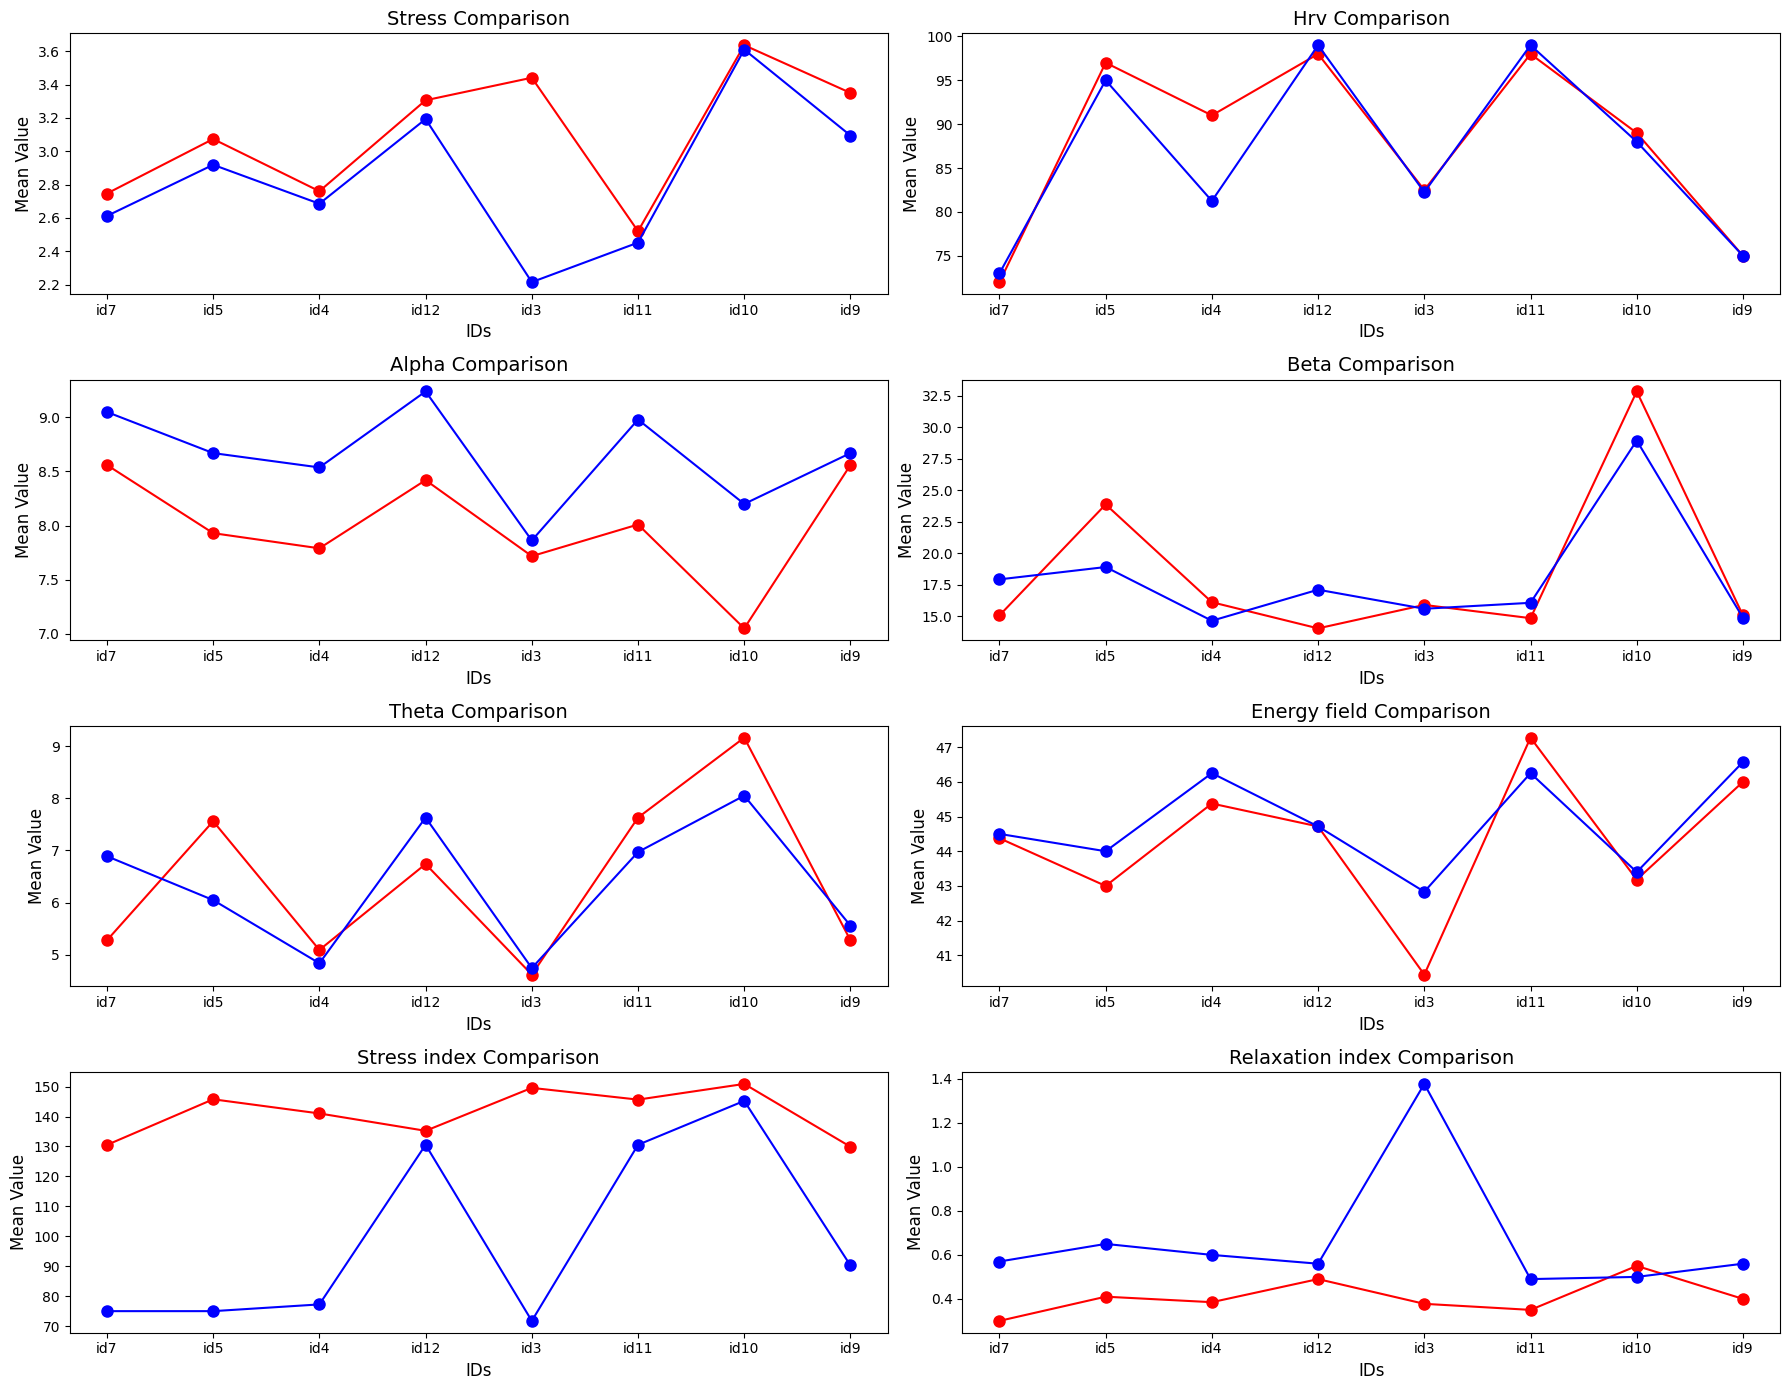

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Path to your experimental data folder
folder_path = "/kaggle/input/experimental"

# Dictionary to hold cleaned DataFrames
cleaned_dfs = {}

# Read, clean, and store each file
for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        
        # Clean column names (convert to lowercase and strip whitespace)
        df.columns = [col.strip().lower() for col in df.columns]
        
        # Fill NaNs with column mean for numeric columns
        df = df.apply(lambda x: x.fillna(x.mean()) if x.dtype != 'O' else x)
        
        # Save to dictionary
        cleaned_dfs[file_name] = df

# List of categories to plot (e.g., stress, HRV, alpha, beta, theta)
categories = ['stress', 'hrv', 'alpha', 'beta', 'theta', 'energy field', 'stress index', 'relaxation index']

# Create a visually appealing plot with high resolution
plt.figure(figsize=(18, 14))  # Increased figure size for better visibility

# Loop through each category and create a subplot
for i, category in enumerate(categories):
    plt.subplot(4, 2, i + 1)  # Create a 4x2 grid of subplots (2 graphs per row)
    
    # Create a list to store means for pre and post
    pre_means = []
    post_means = []

    # Loop over each cleaned DataFrame (e.g., for each ID)
    for file_name, df in cleaned_dfs.items():
        # Check if both pre and post columns exist
        pre_column = category
        post_column = f'post yoga {category}'
        
        # Calculate mean for pre and post for each ID
        if pre_column in df.columns:
            pre_means.append(df[pre_column].mean())
        
        if post_column in df.columns:
            post_means.append(df[post_column].mean())
    
    # Plot the mean values for pre and post data
    plt.plot([name.replace(".csv", "") for name in cleaned_dfs.keys()], pre_means, label=f'Pre {category.capitalize()}', color='red', marker='o', markersize=8)
    plt.plot([name.replace(".csv", "") for name in cleaned_dfs.keys()], post_means, label=f'Post Yoga {category.capitalize()}', color='blue', marker='o', markersize=8)
    
    # Add title and labels for each subplot
    plt.title(f"{category.capitalize()} Comparison", fontsize=14)
    plt.xlabel("IDs", fontsize=12)
    plt.ylabel("Mean Value", fontsize=12)
    
    # Remove legend
    plt.legend().set_visible(False)

# Adjust layout to avoid overlapping subplots
plt.tight_layout()
plt.show()

In [70]:
print(df.columns.tolist())

['date', 'energy field', 'stress', 'alpha', 'beta', 'theta', 'stress index', 'relaxation index', 'hrv', 'post yoga energy field', 'post yoga stress', 'post yoga alpha', 'post yoga beta', 'post yoga theta', 'post yoga stress index', 'post yoga relaxation index', 'post yoga hrv']


Columns: ['date', 'energy field', 'stress', 'alpha', 'beta', 'theta', 'stress index', 'relaxation index', 'hrv', 'post yoga energy field', 'post yoga stress', 'post yoga alpha', 'post yoga beta', 'post yoga theta', 'post yoga stress index', 'post yoga relaxation index', 'post yoga hrv']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


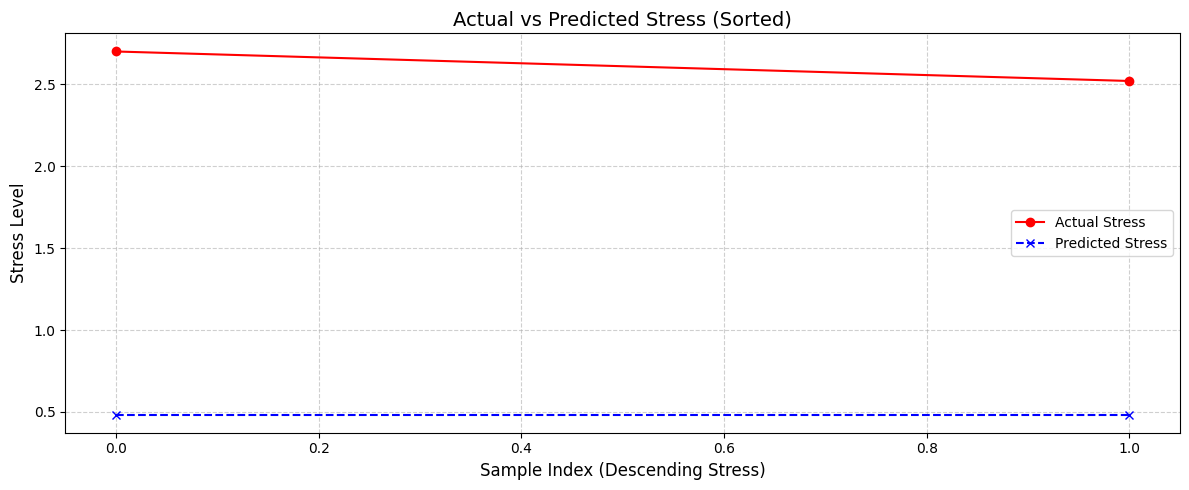

In [71]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Load Dataset and Clean Columns
df = pd.read_csv('/kaggle/input/individual/id4.csv')
df.columns = df.columns.str.strip().str.lower()  # Clean: strip + lowercase
print("Columns:", df.columns.tolist())

# 2. Fill NaNs with column-wise mean
df = df.apply(lambda x: x.fillna(x.mean()) if x.dtype != 'O' else x)

# 3. Define Features (X) and Target (y)
if 'date' in df.columns:
    df = df.drop(columns=['date'])
X = df.drop(columns=['stress'])
y = df['stress']

# 4. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Define RBF Layer
class RBFLayer(Layer):
    def __init__(self, units, gamma=1.0, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = gamma

    def build(self, input_shape):
        self.centers = self.add_weight(name='centers',
                                       shape=(self.units, input_shape[-1]),
                                       initializer='uniform',
                                       trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = tf.expand_dims(inputs, 1) - self.centers
        l2 = tf.reduce_sum(tf.square(diff), axis=-1)
        return tf.exp(-self.gamma * l2)

# 7. Build RBF Model
def build_rbf_model(input_dim, rbf_units=10, gamma=0.5):
    inputs = Input(shape=(input_dim,))
    x = RBFLayer(units=rbf_units, gamma=gamma)(inputs)
    x = Dense(16, activation='relu')(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = build_rbf_model(input_dim=X_train_scaled.shape[1])

# 8. Train the Model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=8, validation_split=0.2, verbose=0)

# Predict
y_pred = model.predict(X_test_scaled).flatten()

# Sort for visual clarity
y_test_sorted = y_test.reset_index(drop=True).sort_values(ascending=False).reset_index(drop=True)
y_pred_sorted = pd.Series(y_pred).sort_values(ascending=False).reset_index(drop=True)

# Plot
plt.figure(figsize=(12, 5))

# Actual values
plt.plot(y_test_sorted, color='red', linestyle='-', marker='o', label='Actual Stress')

# Predicted values
plt.plot(y_pred_sorted, color='blue', linestyle='--', marker='x', label='Predicted Stress')

# Formatting
plt.title("Actual vs Predicted Stress (Sorted)", fontsize=14)
plt.xlabel("Sample Index (Descending Stress)", fontsize=12)
plt.ylabel("Stress Level", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

Pre-Yoga Chakras Detected: 7
Post-Yoga Chakras Detected: 7


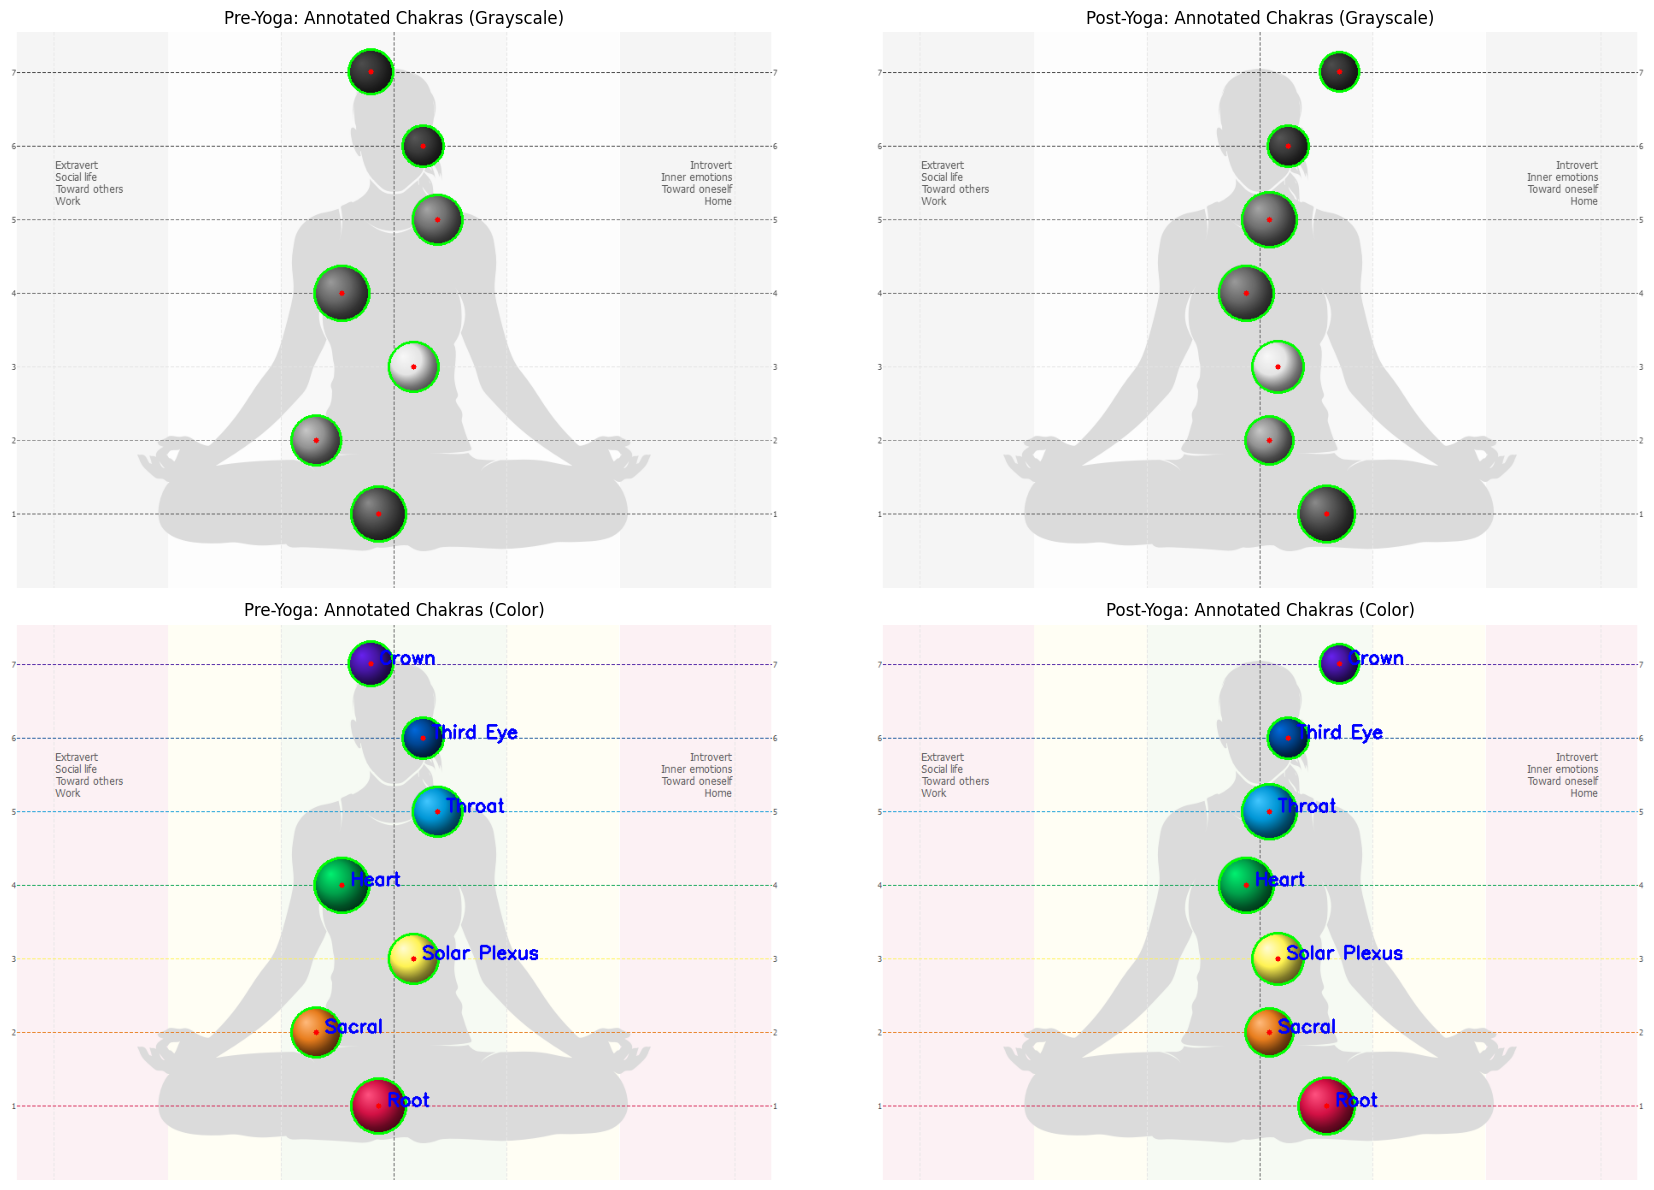

In [72]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# File paths
pre_path = "/kaggle/input/keerthi-chakra1/keerthi pre 06052025.png"
post_path = "/kaggle/input/keerthi-chakra1/keerthi post 07052025.png"

# Chakra labels
chakra_names = ['Crown', 'Third Eye', 'Throat', 'Heart', 'Solar Plexus', 'Sacral', 'Root']

def detect_chakra_circles(image, expected_chakras=7):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(gray, 5)
    blur = cv2.GaussianBlur(blur, (9, 9), 2)

    circles = cv2.HoughCircles(
        blur,
        cv2.HOUGH_GRADIENT,
        dp=1.2,
        minDist=60,
        param1=50,
        param2=30,
        minRadius=20,
        maxRadius=45
    )

    if circles is not None:
        circles = np.uint16(np.around(circles[0]))
        sorted_circles = sorted(circles, key=lambda x: x[1])
        return sorted_circles[:expected_chakras], gray
    return [], gray

def annotate_chakras(image, chakras, with_labels=True):
    output = image.copy()
    for i, (x, y, r) in enumerate(chakras):
        cv2.circle(output, (x, y), r, (0, 255, 0), 2)  # Green circle
        cv2.circle(output, (x, y), 3, (0, 0, 255), -1) # Red center dot
        if with_labels and i < len(chakra_names):
            cv2.putText(output, chakra_names[i], (x + 10, y),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
    return output

# Load images
pre_img = cv2.imread(pre_path)
post_img = cv2.imread(post_path)

# Detect chakras and get grayscale versions
pre_chakras, pre_gray = detect_chakra_circles(pre_img)
post_chakras, post_gray = detect_chakra_circles(post_img)

# Annotate original color images
pre_annotated = annotate_chakras(pre_img, pre_chakras)
post_annotated = annotate_chakras(post_img, post_chakras)

# Annotate grayscale images (convert to BGR first)
pre_gray_bgr = cv2.cvtColor(pre_gray, cv2.COLOR_GRAY2BGR)
post_gray_bgr = cv2.cvtColor(post_gray, cv2.COLOR_GRAY2BGR)
pre_gray_annotated = annotate_chakras(pre_gray_bgr, pre_chakras, with_labels=False)
post_gray_annotated = annotate_chakras(post_gray_bgr, post_chakras, with_labels=False)

# Print how many were detected
print(f"Pre-Yoga Chakras Detected: {len(pre_chakras)}")
print(f"Post-Yoga Chakras Detected: {len(post_chakras)}")

# Display all images
plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(pre_annotated, cv2.COLOR_BGR2RGB))
plt.title("Pre-Yoga: Annotated Chakras (Color)")
plt.axis('off')

plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(pre_gray_annotated, cv2.COLOR_BGR2RGB))
plt.title("Pre-Yoga: Annotated Chakras (Grayscale)")
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(post_annotated, cv2.COLOR_BGR2RGB))
plt.title("Post-Yoga: Annotated Chakras (Color)")
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(post_gray_annotated, cv2.COLOR_BGR2RGB))
plt.title("Post-Yoga: Annotated Chakras (Grayscale)")
plt.axis('off')

plt.tight_layout()
plt.show()

In [73]:
# Chakra X-position Alignment Analysis
center_x = pre_img.shape[1] // 2

print("\n🧘 Chakra Alignment Comparison (Deviation from Center):")
print(f"{'Chakra':<15}{'Before X':<10}{'After X':<10}{'Change':<10}{'Alignment'}")
print("-" * 60)

for i in range(min(len(pre_chakras), len(post_chakras))):
    a_x = pre_chakras[i][0]   # Pre-Yoga x
    b_x = post_chakras[i][0]  # Post-Yoga x
    a_dev = a_x - center_x
    b_dev = b_x - center_x
    change = abs(a_dev) - abs(b_dev)
    status = "✅ Improved" if abs(b_dev) <= abs(a_dev) else "❌ Worse"
    print(f"{chakra_names[i]:<15}{a_x:<10}{b_x:<10}{change:+d} px     {status}")


🧘 Chakra Alignment Comparison (Deviation from Center):
Chakra         Before X  After X   Change    Alignment
------------------------------------------------------------
Crown          422       542       -64 px     ❌ Worse
Third Eye      483       482       +1 px     ✅ Improved
Throat         500       460       +40 px     ✅ Improved
Heart          388       433       +45 px     ✅ Improved
Solar Plexus   472       470       +2 px     ✅ Improved
Sacral         358       460       +82 px     ✅ Improved
Root           431       527       -58 px     ❌ Worse


In [74]:
import pandas as pd
import re

# Load JSON data
df = pd.read_json('/kaggle/input/biowelldatafinal/Report.json')

# Drop 'name' if present
df.drop(columns=['name'], inplace=True, errors='ignore')

# Extract numeric part from 'energy_field' strings
def extract_energy_value(s):
    match = re.search(r'\d+\.?\d*', str(s))
    return float(match.group()) if match else None

df['energy_field'] = df['energy_field'].apply(extract_energy_value)

# Extract chakra energy and alignment numerics if 'chakras' column exists
def extract_chakra_energy(energy_str):
    match = re.search(r'\d+\.?\d*', str(energy_str))
    return float(match.group()) if match else None

def extract_chakra_alignment(align_str):
    match = re.search(r'\d+', str(align_str))
    return int(match.group()) if match else None

if 'chakras' in df.columns and df['chakras'].notnull().any():
    first_valid = df['chakras'].dropna().iloc[0]
    if isinstance(first_valid, dict):
        chakra_names = first_valid.keys()
        for chakra in chakra_names:
            df[f'{chakra}_energy'] = df['chakras'].apply(
                lambda x: extract_chakra_energy(x.get(chakra, {}).get('energy')) if isinstance(x, dict) else None
            )
            df[f'{chakra}_alignment'] = df['chakras'].apply(
                lambda x: extract_chakra_alignment(x.get(chakra, {}).get('alignment')) if isinstance(x, dict) else None
            )
    df.drop(columns=['chakras'], inplace=True)

# Strip whitespace from column names
df.columns = df.columns.str.strip()

# Fill NaNs using column-wise mean for numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Set pandas display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Styling function to remove trailing zeros nicely
def format_float(val):
    if pd.isna(val):
        return ""
    return ('{0:.4f}'.format(val)).rstrip('0').rstrip('.')  # max 4 decimals, remove trailing zeros

# Apply styling only to numeric columns
styled_df = df.style.format({col: format_float for col in numeric_cols}).set_caption("Cleaned Dataset with NaNs Filled")

# Display styled DataFrame (in notebooks this will render nicely)
display(styled_df)

,energy_field,stress,energy,chakra_alignment,Muladhara_energy,Muladhara_alignment,Svadhisthana_energy,Svadhisthana_alignment,Manipura_energy,Manipura_alignment,Anahata_energy,Anahata_alignment,Vishuddha_energy,Vishuddha_alignment,Ajna_energy,Ajna_alignment,Sahasrara_energy,Sahasrara_alignment
0,57,2.7,57.22,92%,5.8,89,5.7,98,5.2,95,5.8,91,5.3,96,5,91,6.1,82
1,51,2.43,51,92%,5.5,87,4.9,95,5.1,99,5,88,5.1,94,4.2,90,5.4,92
2,49,2.66,49.08,92%,5.6,93,5.4,84,5.5,93,5.4,98,4.6,95,3.9,92,5,87
3,51,3.06,51.27,91%,5.4,91,5.4,96,5.1,98,5.5,74,5.3,98,3.8,96,5.5,83
4,53,2.5,53.25,93%,5.2,91,5,90,5.7,96,5.6,99,4.9,93,4.3,93,5.6,91
5,52,2.43,51.6,87%,5.1,87,5.3,87,5.4,89,5.4,98,5.3,86,4.6,82,5.6,83
6,58,2.85,58,90%,6,85,5.9,95,5.4,92,6,88,5.5,93,5.2,88,6.3,78
7,52,2.55,52,89%,5.7,83,5.1,90,5.3,95,5.2,85,5.3,90,4.5,85,5.6,88
8,50,2.8,50,90%,5.8,90,5.6,80,5.7,90,5.6,95,4.8,90,4,89,5.2,82
9,40,2.76,42,95%,4.6,99,3.8,95,4.3,96,4.8,98,3.7,85,2.8,93,4.5,98


In [75]:
import numpy as np
import pandas as pd
import json
import random
import copy

# Function to slightly vary numeric values
def vary_entry(entry, factor=0.05):
    varied = copy.deepcopy(entry)
    for key in ['energy_field', 'stress', 'alpha', 'beta', 'theta', 'stress_index', 'relaxation_index', 'HRV', 'hrv']:
        if key in varied:
            try:
                val = float(varied[key])
                noise = val * factor * (random.random() - 0.5)
                varied[key] = val + noise
            except (ValueError, TypeError):
                pass  # skip if not numeric
    for chakra in varied.get('chakras', {}):
        for attr in ['energy', 'alignment']:
            try:
                val = float(varied['chakras'][chakra][attr])
                noise = val * factor * (random.random() - 0.5)
                varied['chakras'][chakra][attr] = val + noise
            except (ValueError, TypeError, KeyError):
                pass
    return varied

# Helper function to flatten chakras dict into separate columns
def flatten_chakras(df, prefix):
    chakras_expanded = df['chakras'].apply(pd.Series)
    for chakra in chakras_expanded.columns:
        df[f'{prefix}_{chakra}_energy'] = chakras_expanded[chakra].apply(lambda x: x.get('energy') if isinstance(x, dict) else None)
        df[f'{prefix}_{chakra}_alignment'] = chakras_expanded[chakra].apply(lambda x: x.get('alignment') if isinstance(x, dict) else None)
    df = df.drop(columns=['chakras'])
    return df

# Load JSON files
with open('/kaggle/input/prevspostbiowell/Reportpre.json') as f:
    pre_data_original = json.load(f)
with open('/kaggle/input/prevspostbiowell/Reportpost.json') as f:
    post_data_original = json.load(f)

# Generate 176 synthetic entries with slight variations
n_samples = 176
pre_data = [vary_entry(random.choice(pre_data_original)) for _ in range(n_samples)]
post_data = [vary_entry(random.choice(post_data_original)) for _ in range(n_samples)]

# Create DataFrames
df_pre = pd.DataFrame(pre_data)
df_post = pd.DataFrame(post_data)

# Flatten chakras
df_pre = flatten_chakras(df_pre, 'Pre')
df_post = flatten_chakras(df_post, 'Post')

# Drop 'name' and 'session_date' columns
df_pre = df_pre.drop(columns=['name'], errors='ignore')
df_post = df_post.drop(columns=['name', 'session_date'], errors='ignore')

# Select main columns to keep for comparison
main_cols_pre = ['energy_field', 'stress', 'alpha', 'beta', 'theta', 'stress_index', 'relaxation_index', 'HRV']
main_cols_post = ['energy_field', 'stress', 'alpha', 'beta', 'theta', 'stress_index', 'relaxation_index', 'hrv']

# Chakra columns for pre and post (auto-detect)
pre_chakra_cols = [col for col in df_pre.columns if col.startswith('Pre_')]
post_chakra_cols = [col for col in df_post.columns if col.startswith('Post_')]

# Rename columns with suffixes
df_pre = df_pre.rename(columns={col: f"{col}_Pre" for col in main_cols_pre + pre_chakra_cols})
df_post = df_post.rename(columns={col: f"{col}_Post" for col in main_cols_post + post_chakra_cols})

# Subset to only those renamed columns
df_pre_subset = df_pre[[f"{col}_Pre" for col in main_cols_pre] + [col for col in df_pre.columns if col.endswith('_Pre') and col.startswith('Pre_')]]
df_post_subset = df_post[[f"{col}_Post" for col in main_cols_post] + [col for col in df_post.columns if col.endswith('_Post') and col.startswith('Post_')]]

# Reset index to align rows by index
df_pre_subset = df_pre_subset.reset_index(drop=True)
df_post_subset = df_post_subset.reset_index(drop=True)

# Concatenate side-by-side
df_compare = pd.concat([df_pre_subset, df_post_subset], axis=1)

# Replace inf and -inf with NaN
df_compare.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaNs with mean
numeric_cols = df_compare.select_dtypes(include=['float64', 'int64']).columns
df_compare[numeric_cols] = df_compare[numeric_cols].fillna(df_compare[numeric_cols].mean())

# Order metrics and chakra columns
cols_ordered = []
for metric in main_cols_pre:
    cols_ordered.append(f"{metric}_Pre")
    post_metric = metric if metric != 'HRV' else 'hrv'
    cols_ordered.append(f"{post_metric}_Post")

chakras = ['Muladhara', 'Svadhisthana', 'Manipura', 'Anahata', 'Vishuddha', 'Ajna', 'Sahasrara']
for chakra in chakras:
    cols_ordered.append(f"Pre_{chakra}_energy_Pre")
    cols_ordered.append(f"Post_{chakra}_energy_Post")
    cols_ordered.append(f"Pre_{chakra}_alignment_Pre")
    cols_ordered.append(f"Post_{chakra}_alignment_Post")

# Ensure all columns exist
cols_ordered = [col for col in cols_ordered if col in df_compare.columns]
df_compare = df_compare[cols_ordered]

# Format floats for readability
def format_float(x):
    if pd.isna(x):
        return ""
    try:
        return ('{0:.4f}'.format(float(x))).rstrip('0').rstrip('.')
    except Exception:
        return x

for col in numeric_cols:
    if col in df_compare.columns:
        df_compare[col] = df_compare[col].apply(format_float)

# Display all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Show the final dataset
display(df_compare)

,energy_field_Pre,energy_field_Post,stress_Pre,stress_Post,alpha_Pre,alpha_Post,beta_Pre,beta_Post,theta_Pre,theta_Post,stress_index_Pre,stress_index_Post,relaxation_index_Pre,relaxation_index_Post,HRV_Pre,hrv_Post,Pre_Muladhara_energy_Pre,Post_Muladhara_energy_Post,Pre_Muladhara_alignment_Pre,Post_Muladhara_alignment_Post,Pre_Svadhisthana_energy_Pre,Post_Svadhisthana_energy_Post,Pre_Svadhisthana_alignment_Pre,Post_Svadhisthana_alignment_Post,Pre_Manipura_energy_Pre,Post_Manipura_energy_Post,Pre_Manipura_alignment_Pre,Post_Manipura_alignment_Post,Pre_Anahata_energy_Pre,Post_Anahata_energy_Post,Pre_Anahata_alignment_Pre,Post_Anahata_alignment_Post,Pre_Vishuddha_energy_Pre,Post_Vishuddha_energy_Post,Pre_Vishuddha_alignment_Pre,Post_Vishuddha_alignment_Post,Pre_Ajna_energy_Pre,Post_Ajna_energy_Post,Pre_Ajna_alignment_Pre,Post_Ajna_alignment_Post,Pre_Sahasrara_energy_Pre,Post_Sahasrara_energy_Post,Pre_Sahasrara_alignment_Pre,Post_Sahasrara_alignment_Post
0,35.7657,42.4934,2.9875,2.8124,6.9267,7.2857,4.478,10.7935,5.0874,7.8894,57.5143,3.2257,26.3836,7.9737,29.3318,66.444,4.5176,4.757,92.3702,94.494209,3.8912,4.1417,98.4229,95.974693,4.2559,4.4152,91.5453,89.940306,4.3974,5.1772,95.0348,91.289564,3.1725,3.0671,94.9526,96.285894,2.7758,2.8824,96.7556,96.503504,3.8262,3.7859,88.3482,95.106441
1,55.6614,46.3765,2.6767,2.7137,6.4394,7.1356,4.0656,11.5666,5.1713,8.1216,50.142,3.313,32.6763,7.8635,37.741,68.745,5.948,5.7174,84.5292,96.229035,5.3548,4.8967,92.3611,96.394673,5.3924,5.3463,91.1164,90.624116,5.1615,5.9768,84.9852,84.382971,4.8792,3.894,90.5293,99.963793,4.6726,3.418,87.4244,96.212533,5.8239,3.9091,77.0616,85.487014
2,50.4179,45.225,2.8866,2.6936,7.0716,7.4532,4.5123,11.3661,5.3988,7.7563,58.1998,3.2649,26.358,8.1949,32.2343,71.7095,5.3839,5.3675,81.1406,95.856335,4.9292,4.8304,85.0493,99.697716,5.2719,5.3021,87.7265,101.202225,5.1023,5.7139,84.518,92.610118,5.083,3.3628,88.345,95.051543,4.3853,3.448,82.0955,100.343083,5.5138,4.4111,78.4468,90.827145
3,46.8235,40.2849,3.0042,2.704,7.2569,7.2662,4.9063,10.6577,5.4417,8.0875,58.5337,3.3458,26.6211,7.7194,28.64,65.6579,6.0333,4.6226,95.492,100.731887,5.3715,3.7111,92.6701,93.35302,5.5876,4.3243,87.6128,95.353022,6.3751,4.8146,82.7296,100.309381,4.1357,3.7384,98.0261,84.922998,3.8625,2.8698,90.9339,90.777819,4.4794,4.539,91.3008,96.382561
4,53.993,45.5654,2.6718,2.6797,6.5952,7.1025,3.9574,11.3688,5.193,7.8856,48.9391,3.2253,33.3213,7.8059,37.5404,68.141,6.011,5.8428,81.9035,95.51547,5.3445,5.0184,91.5911,97.202172,5.51,5.4209,87.992,92.471922,5.1295,5.8393,88.2152,83.279719,4.8882,3.8503,91.4838,100.037791,4.5649,3.3447,85.0389,96.171617,5.8014,3.9218,77.079,86.196979
5,48.9074,44.9581,2.8511,2.6604,6.9392,6.8362,4.4613,11.4865,5.2261,8.0831,53.2277,3.3291,29.475,8.0518,36.5636,68.1972,5.6729,5.6966,91.1926,94.558304,5.6409,4.9402,79.0919,96.467926,5.5795,5.3115,88.7272,93.602364,5.5631,5.9447,93.9216,83.823253,4.9147,3.8478,87.8763,98.95574,4.0104,3.4182,87.6256,94.664935,5.273,3.9208,80.5859,87.801394
6,44.9191,46.4779,3.3335,2.6563,7.7627,7.5044,4.9803,11.2563,5.725,7.9903,64.9568,3.3455,23.5215,8.0581,26.1792,70.3217,5.5704,5.5917,92.4388,96.303147,5.0686,4.9125,92.8909,99.12608,5.6563,5.4143,89.0802,97.286755,6.0026,5.6098,91.8776,92.094456,3.8829,3.3427,86.9363,97.102384,3.8717,3.3277,99.5077,100.398127,4.2569,4.3655,99.67,92.248385
7,35.5543,39.4543,3.0402,2.7256,7.2275,7.2266,4.4679,10.5617,5.1616,7.9186,57.3532,3.3984,27.4083,7.73,30.5028,66.7419,4.3958,4.5736,91.7548,97.610614,3.8209,3.7157,100.6151,94.610499,4.2317,4.3001,93.3452,96.696034,4.4817,4.8483,92.2458,96.377518,3.0449,3.7044,93.8554,86.745951,2.7558,2.7969,93.8482,91.36168,3.8957,4.6116,90.2837,96.2059
8,38.1713,47.8543,3.5222,2.8022,2.878,8.4231,4.1655,3.2077,10.3006,5.6661,35.2631,29.3106,4.1982,76.792,26.9235,68.3407,4.957,5.523,101.2244,101.234636,5.0657,5.0018,89.6596,90.446276,4.4801,5.067,88.9608,95.643493,4.8818,6.0799,82.7484,97.325083,2.741,4.2167,93.3871,91.236297,2.9889,3.5455,92.1192,92.799976,3

In [76]:
import numpy as np
import pandas as pd

target_col = 'stress_Post'

# Convert all columns to numeric where possible
df_compare_numeric = df_compare.apply(pd.to_numeric, errors='coerce')

# Check dtype of target column
print(f"{target_col} dtype:", df_compare_numeric[target_col].dtype)

# Prepare features and target
features = df_compare_numeric.drop(columns=[target_col], errors='ignore')
y = df_compare_numeric[target_col]

# Now you can split features and target for train/test/val
from sklearn.model_selection import train_test_split

# Split 50% train, 30% test, 20% validation
X_train, X_temp, y_train, y_temp = train_test_split(features, y, test_size=0.5, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)  # 0.4*0.5=0.2 total validation

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)
print("Validation size:", X_val.shape)

stress_Post dtype: float64
Train size: (88, 43)
Test size: (52, 43)
Validation size: (36, 43)


In [77]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')  # or median if you prefer

# Fit imputer on training features only, then transform train/test/val
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
X_val_imputed = imputer.transform(X_val)

# Then scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

# Create SVR model with RBF kernel
svr_rbf = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Train model
svr_rbf.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = svr_rbf.predict(X_train_scaled)
y_test_pred = svr_rbf.predict(X_test_scaled)
y_val_pred = svr_rbf.predict(X_val_scaled)

# Evaluate
def print_metrics(y_true, y_pred, split_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{split_name} RMSE: {rmse:.4f}")
    print(f"{split_name} R^2: {r2:.4f}\n")

print_metrics(y_train, y_train_pred, 'Train')
print_metrics(y_test, y_test_pred, 'Test')
print_metrics(y_val, y_val_pred, 'Validation')

Train RMSE: 0.0798
Train R^2: 0.8933

Test RMSE: 0.1176
Test R^2: 0.7472

Validation RMSE: 0.1244
Validation R^2: 0.7165



In [78]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'epsilon': [0.01, 0.1, 0.5],
    'kernel': ['rbf']
}

# Grid search on training data
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Replace model with best estimator
svr_rbf = grid_search.best_estimator_

# Retrain on full training data
svr_rbf.fit(X_train_scaled, y_train)

# Predictions again
y_train_pred = svr_rbf.predict(X_train_scaled)
y_test_pred = svr_rbf.predict(X_test_scaled)
y_val_pred = svr_rbf.predict(X_val_scaled)

# Evaluation remains the same
print_metrics(y_train, y_train_pred, 'Train')
print_metrics(y_test, y_test_pred, 'Test')
print_metrics(y_val, y_val_pred, 'Validation')

# Now these lines will work
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", -grid_search.best_score_)  # Convert from negative MSE

Train RMSE: 0.0097
Train R^2: 0.9984

Test RMSE: 0.0942
Test R^2: 0.8377

Validation RMSE: 0.1038
Validation R^2: 0.8025

Best parameters: {'C': 10.0, 'epsilon': 0.01, 'kernel': 'rbf'}
Best cross-validation score: 0.01672966094713498


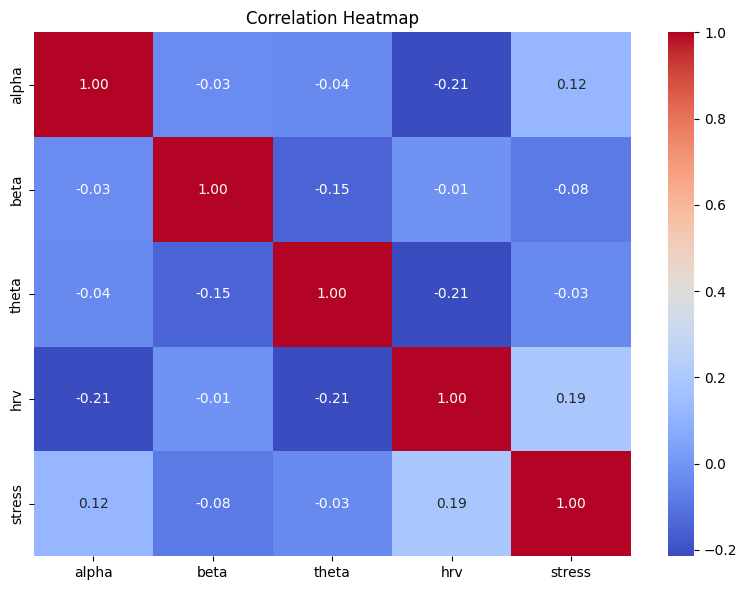

Tuning SVR...
Tuning MLP...
Tuning RF...


('SVR', 12.881987325544864, 3.589148551612884, -0.16511912114457195)

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Mock Data
np.random.seed(42)
df = pd.DataFrame({
    'alpha': np.random.rand(100),
    'beta': np.random.rand(100),
    'theta': np.random.rand(100),
    'hrv': np.random.rand(100) * 100,
    'stress': np.random.rand(100) * 10
})

# Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

# Feature/Target Selection
feature_columns = ['alpha', 'beta', 'theta', 'hrv']
target_column = 'stress'
df_clean = df.dropna(subset=feature_columns + [target_column])
X = df_clean[feature_columns].values
y = df_clean[target_column].values

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVR Pipeline
svr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('svr', SVR(kernel='rbf'))
])
svr_param_dist = {
    'svr__C': [0.1, 1, 10],
    'svr__epsilon': [0.1],
    'svr__gamma': ['scale']
}

# MLP Pipeline
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=3)),
    ('mlp', MLPRegressor(max_iter=7000, random_state=42))
])
mlp_param_dist = {
    'mlp__hidden_layer_sizes': [(50,), (100,)],
    'mlp__activation': ['relu'],
    'mlp__alpha': [1e-4],
    'mlp__learning_rate_init': [0.001, 0.01],
    'mlp__early_stopping': [True]
}

# Random Forest Pipeline
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42))
])
rf_param_dist = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [None, 10, 20]
}

# Hyperparameter Tuning
svr_search = RandomizedSearchCV(svr_pipeline, svr_param_dist, n_iter=3, cv=3, scoring='neg_mean_squared_error', verbose=0)
mlp_search = RandomizedSearchCV(mlp_pipeline, mlp_param_dist, n_iter=3, cv=3, scoring='neg_mean_squared_error', verbose=0)
rf_search = RandomizedSearchCV(rf_pipeline, rf_param_dist, n_iter=3, cv=3, scoring='neg_mean_squared_error', verbose=0)

# Fit Models
print("Tuning SVR...")
svr_search.fit(X_train, y_train)
print("Tuning MLP...")
mlp_search.fit(X_train, y_train)
print("Tuning RF...")
rf_search.fit(X_train, y_train)

# Choose Best Model
all_models = {
    'SVR': svr_search,
    'MLP': mlp_search,
    'RF': rf_search
}
best_name = max(all_models, key=lambda k: all_models[k].best_score_)
best_model = all_models[best_name].best_estimator_

# Predict and Evaluate
y_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_pred)

(best_name, test_mse, test_rmse, test_r2)

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Define alignment columns first
alignment_cols = [
    'Post_Muladhara_alignment_Post', 'Post_Svadhisthana_alignment_Post', 'Post_Manipura_alignment_Post',
    'Post_Anahata_alignment_Post', 'Post_Vishuddha_alignment_Post', 'Post_Ajna_alignment_Post',
    'Post_Sahasrara_alignment_Post'
]

# Check which ones are missing from your dataframe
print([col for col in alignment_cols if col not in df.columns])  # Use your actual DataFrame name

['Post_Muladhara_alignment_Post', 'Post_Svadhisthana_alignment_Post', 'Post_Manipura_alignment_Post', 'Post_Anahata_alignment_Post', 'Post_Vishuddha_alignment_Post', 'Post_Ajna_alignment_Post', 'Post_Sahasrara_alignment_Post']


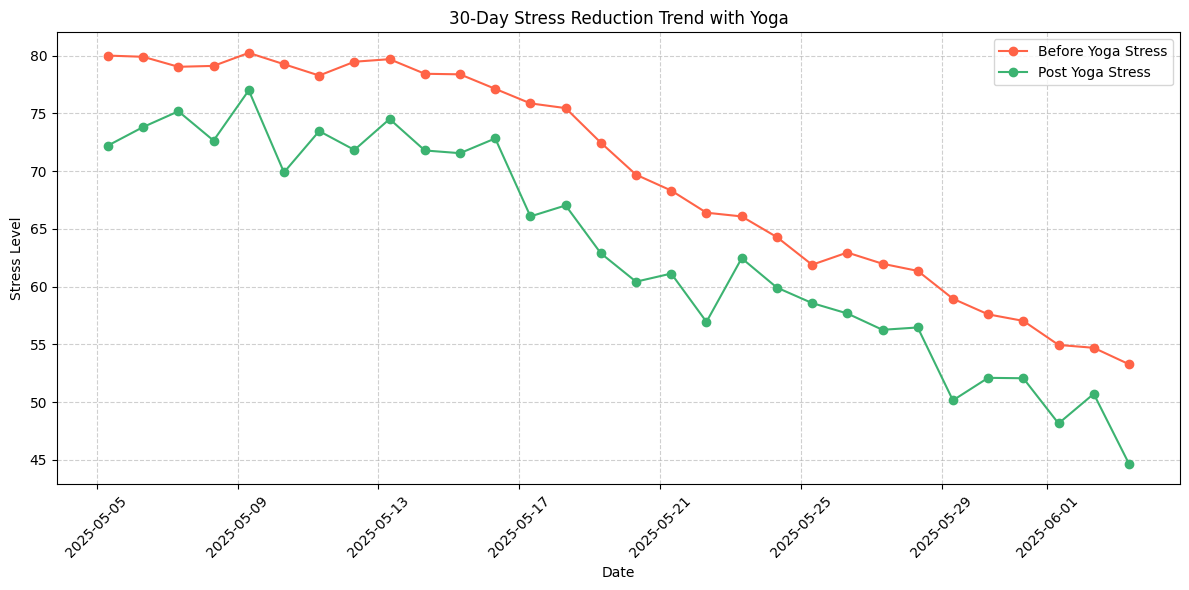

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Generate 30 days of data
dates = pd.date_range(end=pd.Timestamp.today(), periods=30)

# Create a realistic stress trend (simulating a yoga user's experience)
np.random.seed(42)  # For reproducibility

# Start with higher stress and introduce gradual but irregular decrease
stress = [80]
for _ in range(1, 30):
    change = np.random.normal(loc=-0.7, scale=1.2)  # slight downward trend with noise
    new_value = max(stress[-1] + change, 35)  # Prevent values from going too low
    stress.append(new_value)

# Post yoga stress is lower, but still varies
post_yoga_stress = [s - np.random.uniform(3, 10) for s in stress]
post_yoga_stress = [max(val, 30) for val in post_yoga_stress]  # Clamp minimum

# Create DataFrame
df = pd.DataFrame({
    'Date': dates,
    'Stress': stress,
    'Post Yoga stress': post_yoga_stress
})

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Stress'], marker='o', linestyle='-', label='Before Yoga Stress', color='tomato')
plt.plot(df['Date'], df['Post Yoga stress'], marker='o', linestyle='-', label='Post Yoga Stress', color='mediumseagreen')

plt.title('30-Day Stress Reduction Trend with Yoga')
plt.xlabel('Date')
plt.ylabel('Stress Level')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

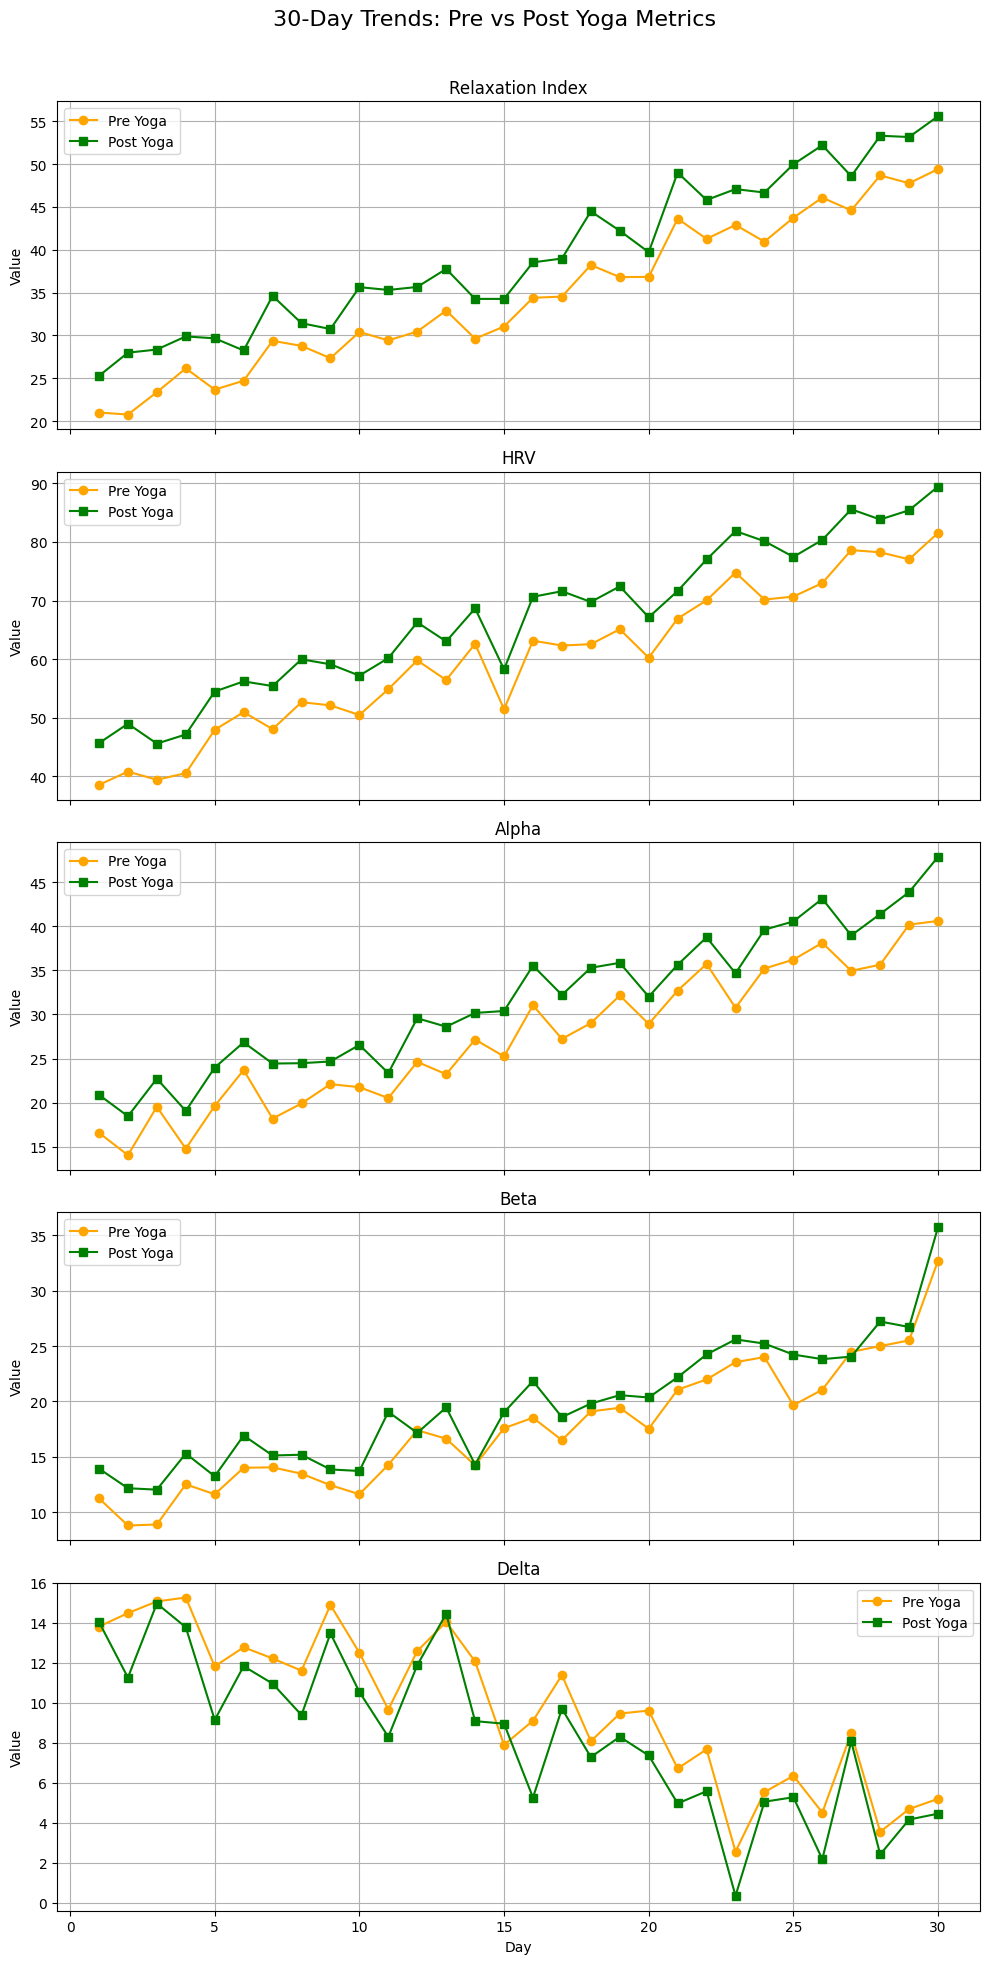

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# Simulate 30-day data for each metric (pre and post yoga)
np.random.seed(42)
days = np.arange(1, 31)

# Generate realistic wellness trends with minor fluctuations
def simulate_trend(start_pre, end_pre, variation=1.5, post_improvement=5):
    pre = np.linspace(start_pre, end_pre, 30) + np.random.normal(0, variation, 30)
    post = pre + np.random.normal(post_improvement, 1.2, 30)
    return pre, post

metrics = {
    'Relaxation Index': simulate_trend(20, 50, variation=2, post_improvement=5),
    'HRV': simulate_trend(40, 80, variation=3, post_improvement=7),
    'Alpha': simulate_trend(15, 40, variation=2, post_improvement=4),
    'Beta': simulate_trend(10, 25, variation=2, post_improvement=2),
    # For Delta, post yoga values should DECREASE, so use negative post_improvement
    'Delta': simulate_trend(15, 5, variation=1.5, post_improvement=-1.5)
}

# Plotting
fig, axs = plt.subplots(5, 1, figsize=(10, 20), sharex=True)
fig.suptitle('30-Day Trends: Pre vs Post Yoga Metrics', fontsize=16)

for i, (metric, (pre, post)) in enumerate(metrics.items()):
    axs[i].plot(days, pre, marker='o', label='Pre Yoga', color='orange')
    axs[i].plot(days, post, marker='s', label='Post Yoga', color='green')
    axs[i].set_title(metric)
    axs[i].set_ylabel('Value')
    axs[i].legend()
    axs[i].grid(True)

axs[-1].set_xlabel('Day')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()